<a href="https://colab.research.google.com/github/Mjauu/text-mining/blob/master/sentiment-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text Mining:
Zbiór Danych sentyment_movies.csv zawiera recenzję filmów z portalu branżowego, wraz ze zmienną zawierającą informację, czy recenzja jest pozytywna, czy negatywna.

- Wskaż, które słowa są najbardziej charakterystyczne dla recenzji pozytywnych, a które dla negatywnych. - OK
- Pamiętaj o filtrowaniu słów stanowiących szum, oraz o wybieraniu tych kategorii słów, które mogą być adekwatne do zadania. - OK
- Za pomocą znanych Ci metod uczenia maszynowego sprawdź, czy istnieją jakieś zgrupowania współwystępujących ze sobą słów.

- https://www.kaggle.com/oumaimahourrane/sentiment-analysis-ml-models-comparison
- https://www.kaggle.com/oumaimahourrane/imdb-reviews/kernels
- https://www.kaggle.com/sergiadi/iet-x-mlda-workshop
- https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
- https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

I follow sklearn proposal for text feature extraction, which means I will be extracting numerical features from text content.


1.   Tokenizing strings - each token gets integer id
2.   Counting the occurrences of tokens
3.   Normalizing and weighting with 


spacy en_core_web_sm - medium-size English language model



# 0. Import all the staff

In [1]:
import re
import nltk
import random
import spacy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go

from spacy import displacy
from nltk.corpus import stopwords
from textblob import TextBlob, Word
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from time import time

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

stop = stopwords.words('english')
sp = spacy.load("en_core_web_sm")

plt.style.use('fivethirtyeight')
py.init_notebook_mode(connected=True)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Configure notebook

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1. Read data

## 1.1 Get data from GitHub


1.   Comma-separated values
2.   Latin encoding


In [3]:
url = 'https://raw.githubusercontent.com/Mjauu/text-mining/master/sentiment_movies.csv'
data = pd.read_csv(url, encoding='latin-1')
data.head()

,SentimentText,Sentiment
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1


## 1.2. Describe

In [4]:
data.describe()

,Sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


## 1.3 Check the balance

In [5]:
data['Sentiment'].value_counts()

1    12500
0    12500
Name: Sentiment, dtype: int64

## 1.4 Get sample text

In [6]:
random.sample(data['SentimentText'].values.tolist(), 1)

['Many lead characters Hideo Gosha\'s 1969 film "Hitokiri" (manslayer; aka "Tenchu" -- heaven\'s punishment) actual historical figures (in "western" name-order format): Ryoma Sakamoto, Hampeita Takechi, Shimbei Tanaka, Izo Okada, ____ Anenokoji. name "Hitokiri," historical term, refers group four super-swordsmen carried numerous assassinations key figures ruling Tokugawa Shogunate mid-1800s orders Takechi, leader "Loyalist" (i.e. ultra-nationalist, pro-Emperor) faction Tosa clan. struggle about? Sad say, won\'t find film. "Brilliant History Lesson" indeed!<br /><br />No, Gosha much interested showing usual bloody slicing dicing (at absurd length) inner torment not-very-bright killer Izo Okada revealing actual history. Sakamoto, example, someone historical significance, considered father Imperial Japanese Navy. closest Gosha comes providing history lesson scene Sakamoto, Takechi considers traitor Loyalist cause, comes Takechi\'s mansion try sway ideologically. begins talking internation

# 2. Find out data properties

## 2.1 Number of words
Negative sentiments could contain a lesser amount of words than the positive ones.

In [7]:
data['WordCount'] = data['SentimentText'].apply(lambda x: len(str(x).split()))
data[['SentimentText','WordCount','Sentiment']].head()

,SentimentText,WordCount,Sentiment
0,"first think another Disney movie, might good, ...",52,1
1,"Put aside Dr. House repeat missed, Desperate H...",86,0
2,"big fan Stephen King's work, film made even gr...",193,1
3,watched horrid thing TV. Needless say one movi...,63,0
4,truly enjoyed film. acting terrific plot. Jeff...,65,1


Longest sentense.

In [8]:
print('Longest sentense: ', data.loc[data['WordCount'].idxmax(), 'WordCount'], ' words')
data.loc[data['WordCount'].idxmax(), 'SentimentText']

Longest sentense:  1480  words


'Match 1: Tag Team Table Match Bubba Ray Spike Dudley vs Eddie Guerrero Chris Benoit Bubba Ray Spike Dudley started things Tag Team Table Match Eddie Guerrero Chris Benoit. According rules match, opponents go tables order get win. Benoit Guerrero heated early taking turns hammering first Spike Bubba Ray. German suplex Benoit Bubba took wind Dudley brother. Spike tried help brother, referee restrained Benoit Guerrero ganged corner. Benoit stomping away Bubba, Guerrero set table outside. Spike dashed ring somersaulted top rope onto Guerrero outside! recovering taking care Spike, Guerrero slipped table ring helped Wolverine set up. tandem set double superplex middle rope would put Bubba table, Spike knocked table right brother came crashing down! Guerrero Benoit propped another table corner tried Irish Whip Spike it, Bubba dashed blocked brother. Bubba caught fire lifted opponents back body drops! Bubba slammed Guerrero Spike stomped Wolverine top rope. Bubba held Benoit bay Spike soar Wa

Shortest sentense.

In [9]:
print('Shortest sentense: ', data.loc[data['WordCount'].idxmin(), 'WordCount'], ' words')
data.loc[data['WordCount'].idxmin(), 'SentimentText']

Shortest sentense:  1  words


'Err:510'

In [10]:
data.sort_values(by=['WordCount'], inplace=True)
data[['SentimentText','WordCount']].head()

,SentimentText,WordCount
21102,Err:510,1
11050,movie terrible good effects.,4
19922,Ming Merciless little Bardwork movie foul!,6
916,Adrian Pasdar excellent film. makes fascinatin...,7
15527,wouldn't rent one even dollar rental night.,7


Remove shortest sentense as it brings no value to keep it in dataframe.

In [0]:
data = data.drop(data['WordCount'].idxmin())

Sort by index

In [0]:
data.sort_index(inplace=True)

## 2.2 Number of characters
First remove all whitespaces, then calculate number of remaining characters.

In [13]:
data['CharCount'] = data['SentimentText'].apply(lambda x: len("".join(x.split())))
data[['SentimentText','CharCount','Sentiment']].head()

,SentimentText,CharCount,Sentiment
0,"first think another Disney movie, might good, ...",263,1
1,"Put aside Dr. House repeat missed, Desperate H...",480,0
2,"big fan Stephen King's work, film made even gr...",1076,1
3,watched horrid thing TV. Needless say one movi...,352,0
4,truly enjoyed film. acting terrific plot. Jeff...,413,1


The length of the text varies a lot.

In [31]:
lens = data.SentimentText.str.len()
print('Mean: ', lens.mean())
print('Std: ', lens.std())
print('Max: ', lens.max())

Mean:  933.9395975839034
Std:  718.4445845306224
Max:  9836


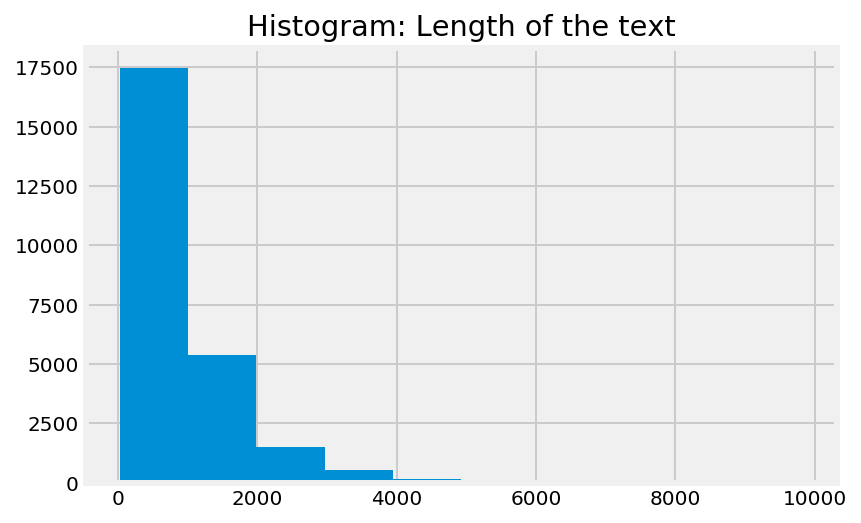

In [34]:
lens.hist()
plt.title('Histogram: Length of the text');

## 2.3 Average word length

In [14]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

data['AvgWordLength'] = data['SentimentText'].apply(lambda x: avg_word(x))
data[['SentimentText','AvgWordLength','Sentiment']].head()

,SentimentText,AvgWordLength,Sentiment
0,"first think another Disney movie, might good, ...",5.057692,1
1,"Put aside Dr. House repeat missed, Desperate H...",5.581395,0
2,"big fan Stephen King's work, film made even gr...",5.575130,1
3,watched horrid thing TV. Needless say one movi...,5.587302,0
4,truly enjoyed film. acting terrific plot. Jeff...,6.353846,1


## 2.4 Number of stopwords
Stopwords are the English words which does not add much meaning to a sentence. I use stopwords from nltk.corpus library, here en_core_web_sm corpus.

In [15]:
print('Example stop words: ', stop[:10])

Example stop words:  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [16]:
print('There are ', len(stop), ' stopwords defined.')

There are  179  stopwords defined.


First lower case all letters, because stopwords.words returns a list of lowercase stop words. Next calculate stopwords.

In [17]:
data['StopWordsCount'] = data['SentimentText'].apply(lambda x: len([x for x in x.split() if x.lower() in stop]))
data[['SentimentText','StopWordsCount','Sentiment']].head()

,SentimentText,StopWordsCount,Sentiment
0,"first think another Disney movie, might good, ...",1,1
1,"Put aside Dr. House repeat missed, Desperate H...",3,0
2,"big fan Stephen King's work, film made even gr...",3,1
3,watched horrid thing TV. Needless say one movi...,1,0
4,truly enjoyed film. acting terrific plot. Jeff...,2,1


## 2.5 Number of numerics

In [18]:
data['NumericsCount'] = data['SentimentText'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
data[['SentimentText','NumericsCount','Sentiment']].head()

,SentimentText,NumericsCount,Sentiment
0,"first think another Disney movie, might good, ...",2,1
1,"Put aside Dr. House repeat missed, Desperate H...",4,0
2,"big fan Stephen King's work, film made even gr...",1,1
3,watched horrid thing TV. Needless say one movi...,0,0
4,truly enjoyed film. acting terrific plot. Jeff...,0,1


## 2.6 Number of uppercase words
Anger or rage could be expressed by writing in UPPERCASE.

In [19]:
data['UppercaseCount'] = data['SentimentText'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
data[['SentimentText','UppercaseCount','Sentiment']].head()

,SentimentText,UppercaseCount,Sentiment
0,"first think another Disney movie, might good, ...",0,1
1,"Put aside Dr. House repeat missed, Desperate H...",1,0
2,"big fan Stephen King's work, film made even gr...",0,1
3,watched horrid thing TV. Needless say one movi...,2,0
4,truly enjoyed film. acting terrific plot. Jeff...,0,1


## 2.7 Show all the properties

In [20]:
data.head(5)

,SentimentText,Sentiment,WordCount,CharCount,AvgWordLength,StopWordsCount,NumericsCount,UppercaseCount
0,"first think another Disney movie, might good, ...",1,52,263,5.057692,1,2,0
1,"Put aside Dr. House repeat missed, Desperate H...",0,86,480,5.581395,3,4,1
2,"big fan Stephen King's work, film made even gr...",1,193,1076,5.575130,3,1,0
3,watched horrid thing TV. Needless say one movi...,0,63,352,5.587302,1,0,2
4,truly enjoyed film. acting terrific plot. Jeff...,1,65,413,6.353846,2,0,0


# 3. Preprocessing

After processing everz output goes into 'SentimentTextNew' column.

## 3.1 Lower case

In [21]:
data['SentimentTextNew'] = data['SentimentText'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data[['SentimentTextNew']].head()

,SentimentTextNew
0,"first think another disney movie, might good, ..."
1,"put aside dr. house repeat missed, desperate h..."
2,"big fan stephen king's work, film made even gr..."
3,watched horrid thing tv. needless say one movi...
4,truly enjoyed film. acting terrific plot. jeff...


## 3.2 Remove URLs

In [22]:
data['SentimentTextNew'] = data['SentimentTextNew'].apply(lambda x: re.sub(r'(?:\@|https?\://)\S+', '', x))
data[['SentimentTextNew']].head()

,SentimentTextNew
0,"first think another disney movie, might good, ..."
1,"put aside dr. house repeat missed, desperate h..."
2,"big fan stephen king's work, film made even gr..."
3,watched horrid thing tv. needless say one movi...
4,truly enjoyed film. acting terrific plot. jeff...


## 3.3 Remove html tags

In [23]:
data['SentimentTextNew'] = data['SentimentTextNew'].apply(lambda x: re.sub(r'<[^>]+>', '', x))
data[['SentimentTextNew']].head()

,SentimentTextNew
0,"first think another disney movie, might good, ..."
1,"put aside dr. house repeat missed, desperate h..."
2,"big fan stephen king's work, film made even gr..."
3,watched horrid thing tv. needless say one movi...
4,truly enjoyed film. acting terrific plot. jeff...


## 3.4 Remove non-letters and non-digits characters

In [24]:
data['SentimentTextNew'] = data['SentimentTextNew'].str.replace('[^\w\s]','')
data[['SentimentTextNew']].head()

,SentimentTextNew
0,first think another disney movie might good it...
1,put aside dr house repeat missed desperate hou...
2,big fan stephen kings work film made even grea...
3,watched horrid thing tv needless say one movie...
4,truly enjoyed film acting terrific plot jeff c...


## 3.5 Remove stop words

In [25]:
data['SentimentTextNew'] = data['SentimentTextNew'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data[['SentimentTextNew']].head()

,SentimentTextNew
0,first think another disney movie might good ki...
1,put aside dr house repeat missed desperate hou...
2,big fan stephen kings work film made even grea...
3,watched horrid thing tv needless say one movie...
4,truly enjoyed film acting terrific plot jeff c...


## 3.6 Lemmatization using spaCy
Convert the word into its root word.

Warning: Time consuming operation!

In [26]:
before = data.loc[4, 'SentimentTextNew']
data['SentimentTextNew'] = data['SentimentTextNew'].apply(lambda x: " ".join(word.lemma_ for word in sp(x)))
data['SentimentTextNew'].head()

0    first think another disney movie may good kid ...
1    put aside dr house repeat miss desperate house...
2    big fan stephen king work film make even great...
3    watch horrid thing tv needless say one movie w...
4    truly enjoy film act terrific plot jeff comb t...
Name: SentimentTextNew, dtype: object

Get sample text and compare results.

In [27]:
print('Before: ', before)
print('After: ', data.loc[4, 'SentimentTextNew'])

Before:  truly enjoyed film acting terrific plot jeff combs talent recognized part flick would change ending death creature far gruesome sci fi channelthere interesting religious messages film jeff combs obviously played messiah figure creature shark prefer represented antichirst particularly frightening scenes end world feel noticed third viewing classic creature feature know many people wont get references christianity watch close youll get
After:  truly enjoy film act terrific plot jeff comb talent recognize part flick would change end death creature far gruesome sci fi channelthere interesting religious message film jeff comb obviously play messiah figure creature shark prefer represent antichirst particularly frightening scene end world feel notice third view classic creature feature know many people will not get reference christianity watch close -PRON- will get


Moyna dodac
- Parts-of-speech - assign a category tag to the tokenized parts of a sentence e.g. identifying words as nouns, verbs, adjectives
- Bag of Words - the number of occurrences of words within the text
- n-grams

## 3.7 Common words

### 3.7.1 Count common words occurrence frequency



In [0]:
freq_common = pd.Series(' '.join(data['SentimentTextNew']).split()).value_counts()

Text(0.5, 1.0, 'Common words')

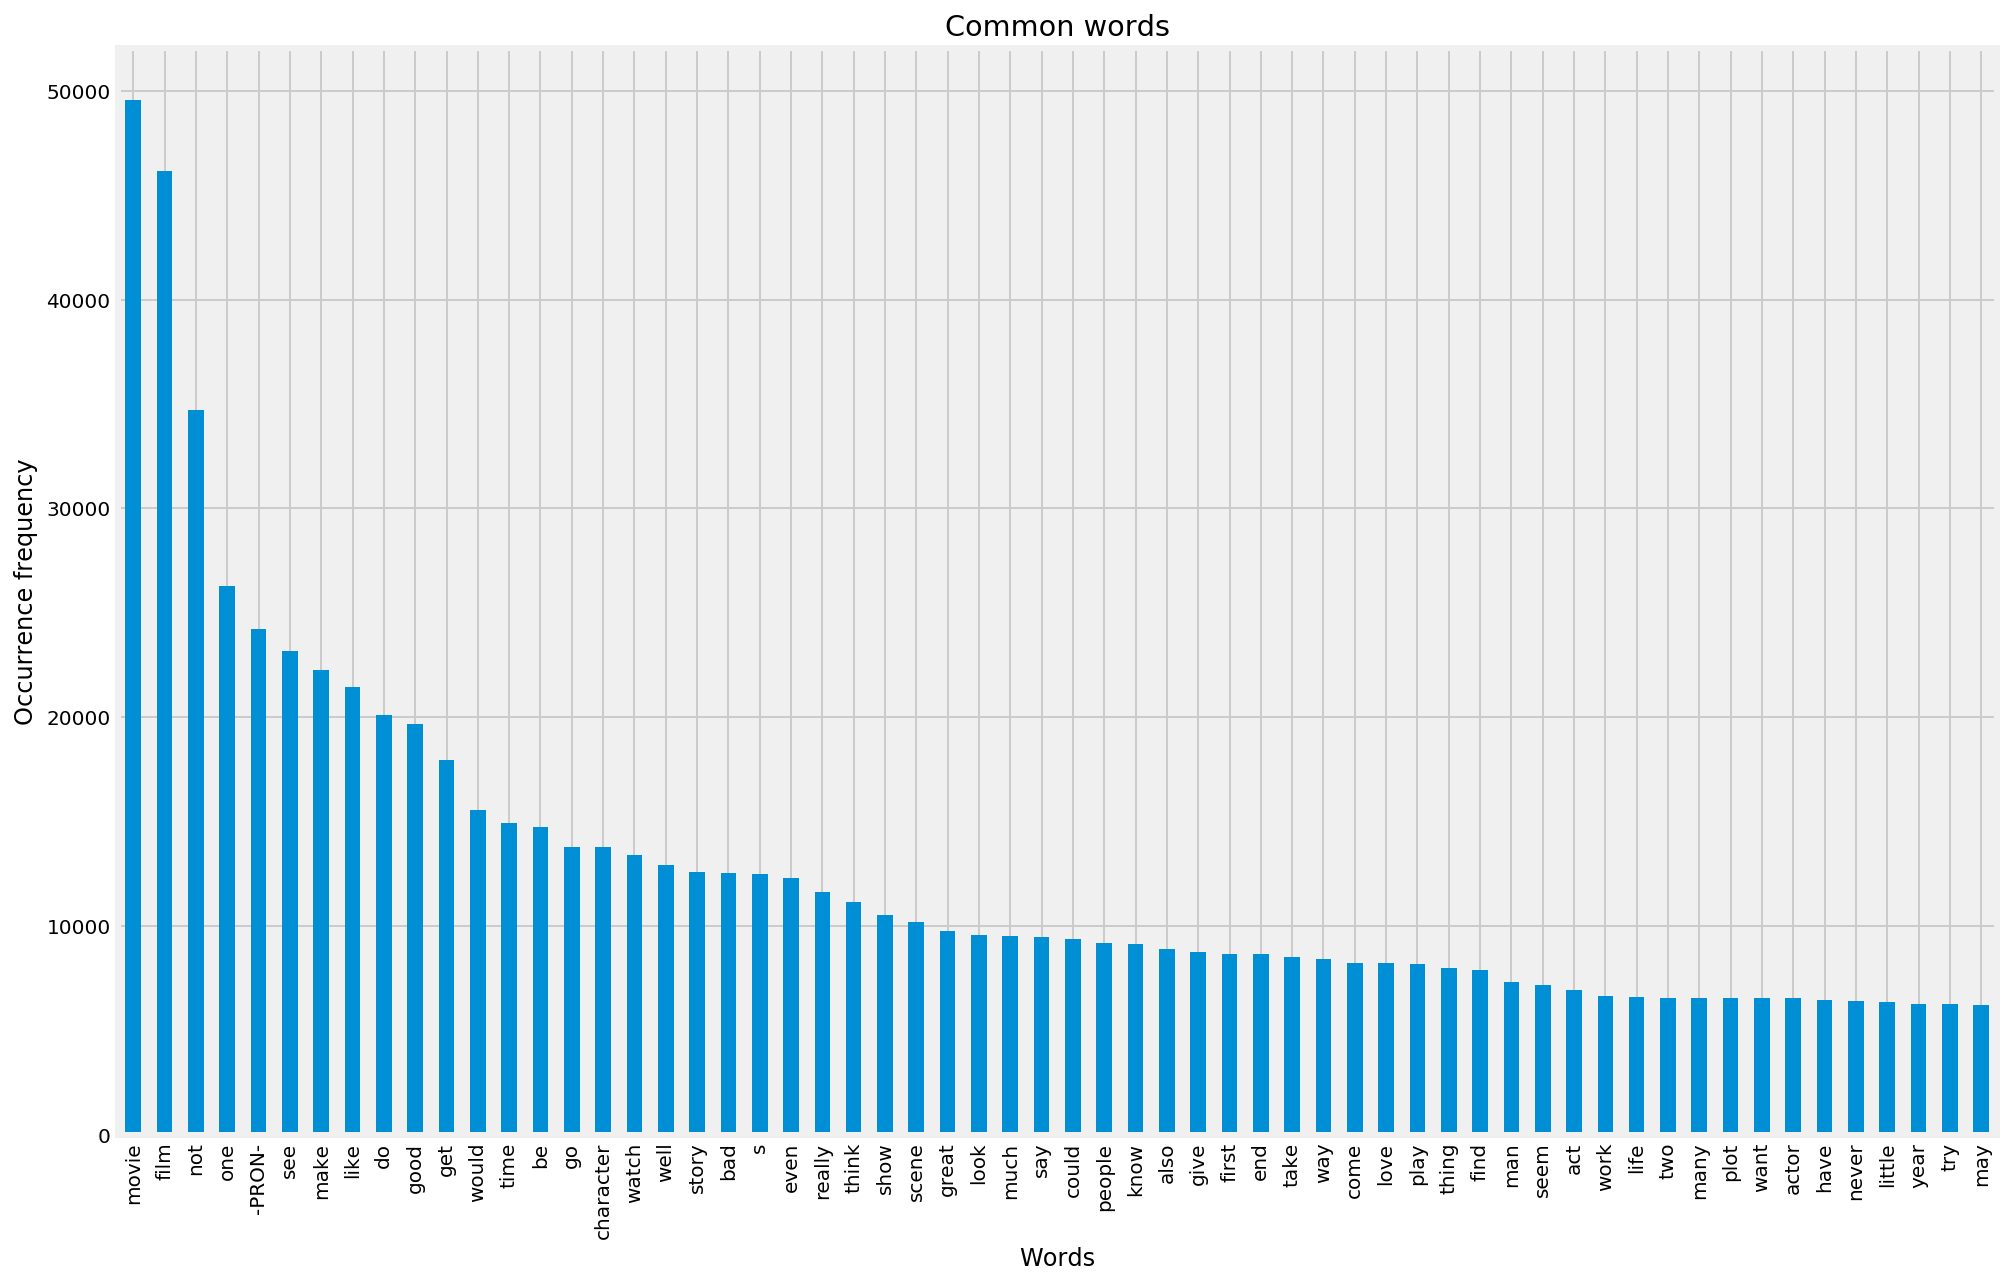

In [115]:
plt.figure(figsize=(15,10))
freq_common[:60].plot.bar()
plt.xlabel('Words')
plt.ylabel('Occurrence frequency')
plt.title('Common words')

### 3.7.2 Remove common words
Remove the first 10 words.

In [0]:
freq_common_10 = list(freq_common[:10].index)
data['SentimentTextNew'] = data['SentimentTextNew'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_common_10))
data['SentimentTextNew'].head()

Check the results.

In [0]:
freq_common_new = pd.Series(' '.join(data['SentimentTextNew']).split()).value_counts()
plt.figure(figsize=(15,10))
freq_common_new[:60].plot.bar()
plt.xlabel('Words')
plt.ylabel('Occurrence frequency')
plt.title('Common words after removing')

## 3.8 Rare words

### 3.8.1 Count rare words occurrence frequency

In [0]:
freq_rare = pd.Series(' '.join(data['SentimentTextNew']).split()).value_counts()
freq_rare

Get the words with only one occurence.

In [0]:
one_occurence = freq_rare[freq_rare==1]
one_occurence

In [0]:
len(one_occurence)

## 3.9 Word cloud

### 3.9.1 Word cloud of negative terms

In [0]:
neg_tweets = data[data.Sentiment == 0]
neg_string = []

for t in neg_tweets.SentimentTextNew:
    neg_string.append(t)

neg_string = pd.Series(neg_string).str.cat(sep=' ')
wordcloud = WordCloud(
    width=1600,
    height=800,
    max_font_size=200,
    colormap='inferno',
    background_color='white').generate(neg_string)

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 3.9.2 Word cloud of positive terms

In [0]:
pos_tweets = data[data.Sentiment == 1]
pos_string = []

for t in pos_tweets.SentimentTextNew:
    pos_string.append(t)

pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(
    width=1600,
    height=800,
    max_font_size=200,
    colormap='viridis',
    background_color='white').generate(pos_string) 

plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

### 3.9.3 Unique negative words


In [0]:
neg_un = pd.Series(neg_string.split())
neg_un = neg_un[~neg_un.isin(pos_un)]
len(neg_un)

In [0]:
wordcloud = WordCloud(
    width=1600,
    height=800,
    max_font_size=200,
    colormap='inferno',
    background_color='white').generate(neg_un.str.cat(sep=' ')) 

plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

### 3.9.4 Unique postive words 

In [0]:
pos_un = pd.Series(pos_string.split())
pos_un = pos_un[~pos_un.isin(neg_un)]
len(pos_un)

In [0]:
wordcloud = WordCloud(
    width=1600,
    height=800,
    max_font_size=200,
    colormap='viridis',
    background_color='white').generate(pos_un.str.cat(sep=' ')) 

plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

# 4. Classification

## 4.1 Split into train and test
Assumption:
- 20% Test
- 80% Train

In [0]:
SEED = 2000
x_train, x_validation, y_train, y_validation = train_test_split(data.SentimentTextNew, data.Sentiment, test_size=.2, random_state=SEED)

## 4.2 Compare classifiers
Classifiers:
- Logistic Regression
- Multinomial NB
- Perceptron

In [0]:
names = ["Logistic Regression", "Multinomial NB", "Perceptron"]
classifiers = [LogisticRegression(), MultinomialNB(), Perceptron()]
zipped_clf = zip(names,classifiers)

## 4.3 Term frequency–inverse document frequency weighting
This scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus

In [0]:
vec = TfidfVectorizer()

Functions to compare classifiers

In [0]:
def acc_summary(pipeline, x_train, y_train, x_test, y_test):
    
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
  
    # Compute the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Compute the precision and recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    # Compute the average precision
    average_precision = average_precision_score(y_test, y_pred)
  
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    print("-"*80)
    return accuracy, precision, recall, average_precision, fpr, tpr


def classifier_comparator(vectorizer=vec, n_features=10000, ngram_range=(1, 3), classifier=zipped_clf):
    result = []
    vectorizer.set_params(max_features=n_features, ngram_range=ngram_range)

    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        clf_acc, prec, rec, avg, fp, tp = acc_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_acc,prec, rec, avg, fp, tp))

    return result


result = classifier_comparator(n_features=100000,ngram_range=(1,3))

In [0]:
acc=[]
names = []
avg_ = []
fp_ = []
tp_ = []

for name, accuracy, prec, rec, avg, fp, tp in result:
    acc.append(accuracy*100)
    names.append(name)

    avg_.append(avg*100)
    fp_.append(fp)
    tp_.append(tp)
trace1 = go.Bar(
    x=names,
    y=acc,
    name='Accuracy percentage (%)'
)
trace3 = go.Bar(
    x=names,
    y=avg_,
    name='Average precision (%)'
)


data = [trace1, trace3]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

In [0]:
data = []
for i in range(0, len(names)):
    trace = go.Scatter(x=fp_[i], y=tp_[i],
                        mode='lines', 
                        name='ROC curve {}'
                               ''.format(names[i]))
    data.append(trace)
    
layout = go.Layout(title='Receiver operating characteristic ',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## 4.1 N-grams
Capture the language structure, like what letter or word is likely to follow the given one

In [0]:
TextBlob(data['SentimentText'][0]).ngrams(2)

TypeError: list indices must be integers or slices, not str

## 4.2 Term frequency - dopracowac
TF = (Number of times term T appears in the particular row) / (number of terms in that row)

In [0]:
#tf1 = (data['SentimentText'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index
#tf1

## 4.3 Inverse Document Frequency - dopracowac
IDF = log(N/n), where, N is the total number of rows and n is the number of rows in which the word was present.

In [0]:
#for i,word in enumerate(tf1['words']):
#  tf1.loc[i, 'idf'] = np.log(data.shape[0]/(len(data[data['SentimentText'].str.contains(word)])))
#
#tf1

# 5. Another aproch

# 5.1 Lemmatise text

In [29]:
def keep_token(t):
    return (t.is_alpha and 
            not (t.is_space or t.is_punct or 
                 t.is_stop or t.like_num))

def lemmatize_doc(doc):
    return [ t.lemma_ for t in doc if keep_token(t)]

docs = [lemmatize_doc(sp(doc)) for doc in data['SentimentText']]

KeyboardInterrupt: ignored